In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import seaborn as sns
import random

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_fscore_support

import joblib

In [33]:
#X_train
filename = "X_train.pkl"
X_train_all = pd.read_pickle(filename)#, skiprows=skip, sep='\t',index_col=0)

#X_test
filename = "X_test.pkl"
X_test_all = pd.read_pickle(filename)#, skiprows=skip, sep='\t',index_col=0)

#y_train
filename = "y_train.pkl"
y_train_all = pd.read_pickle(filename)#, skiprows=skip, sep='\t',index_col=0)

#y_test
filename = "y_test.pkl"
y_test_all = pd.read_pickle(filename)

In [34]:
#drop OHE source columns & unuseful categorical variables
X_train_all.drop(columns=['term','verification_status',
                          'grade','emp_title', 'addr_state',
                          #ALSO, drop redundant columns that new OHE columns provide the info for
                          'debt_settlement_flag',#ALSO, drop columns clearly not predictive of class
                         ],inplace=True) #ALSO, drop date columns

In [35]:
#REPEAT DROPS for X_test
X_test_all.drop(columns=['term','verification_status',
                         'grade','emp_title', 'addr_state',
                         #ALSO, drop redundant columns that new OHE columns provide the info for
                         'debt_settlement_flag',#ALSO, drop columns clearly not predictive of class
                        ],inplace=True) #ALSO, drop date columns

In [36]:
X_train_all.set_index('index',inplace=True)
X_test_all.set_index('index',inplace=True)

#### Exploring calculations, data types, and imputing values in order to create functions that calculate Annualized Return

In [105]:
X_train_all['int_rate'].values

array([0.1239, 0.1299, 0.0818, ..., 0.1099, 0.0824, 0.0697])

In [106]:
y_train_all['loan_status'].values

array([1.0, 0.0, 1.0, ..., 1.0, 0.0, 1.0], dtype=object)

In [107]:
y_train_all['annu_return'].values

array([ 0.09496096, -0.1522351 ,  0.03775913, ...,  0.08887305,
       -0.20260889,  0.03931645])

In [108]:
type((pd.to_datetime(X_train_all['last_pymnt_d']) - pd.to_datetime(X_train_all['issue_d'])).dt.days)

pandas.core.series.Series

In [109]:
print("Test days integer taken from timedelta:")
print((pd.to_datetime('May-2017') - pd.to_datetime('Feb-2015')).days)
print("Test 1st row of annualized return calculation:")
print((24704 / 20000) ** (365 / ((pd.to_datetime('May-2017') - pd.to_datetime('Feb-2015')).days + 30)) - 1)

Test days integer taken from timedelta:
820
Test 1st row of annualized return calculation:
0.09494692576938313


In [110]:
y_train_all.head()

,loan_status,annu_return
798015,1,0.094961
962964,0,-0.152235
534392,1,0.037759
668134,1,0.040470
1068586,1,0.032995


### Create Regression Target Variable: Annualized Return

In [100]:
def calc_annu_return(input_df):
    '''Calculates annual return given cleaned LendingClub dataframe'''
    annu_return = (input_df['total_pymnt'] /
                   input_df['funded_amnt']) ** (365.0 /
                                                ((pd.to_datetime(input_df['last_pymnt_d']) - 
                                                  pd.to_datetime(input_df['issue_d'])).dt.days + 30)) - 1
    return annu_return

In [101]:
def impute_annu_return_to_y(input_df, target_df):
    '''Use input dataframe to compute annualized return and add to target dataframe'''
    target_df['annu_return'] = calc_annu_return(input_df)

#### Impute Annualized Return (taken from X) to Target DataFrame (Y)

In [102]:
impute_annu_return_to_y(X_train_all,y_train_all)

In [103]:
impute_annu_return_to_y(X_test_all,y_test_all)

#### Explore Actual Annualized Returns Data

- Train Set:

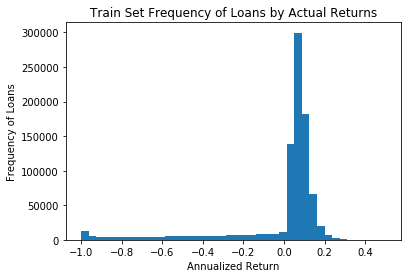

In [118]:
plt.hist(y_train_all['annu_return'],bins=40,range=(-1.0,0.5))
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.title('Train Set Frequency of Loans by Actual Returns')
plt.show()

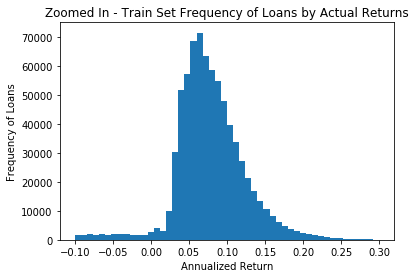

In [119]:
plt.hist(y_train_all['annu_return'],bins=50,range=(-0.1,0.3))
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.title('Zoomed In - Train Set Frequency of Loans by Actual Returns')
plt.show()

- Test Set:

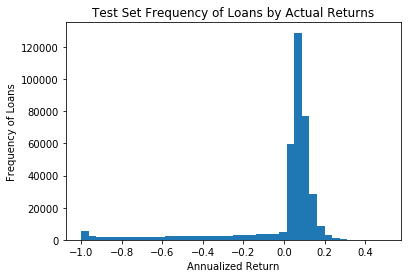

In [122]:
plt.hist(y_test_all['annu_return'],bins=40,range=(-1.0,0.5))
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.title('Test Set Frequency of Loans by Actual Returns')
plt.show()

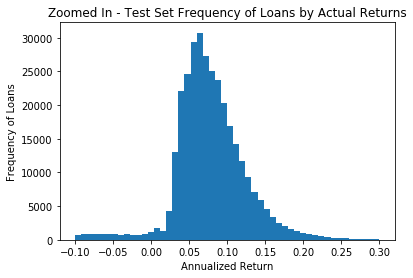

In [123]:
plt.hist(y_test_all['annu_return'],bins=50,range=(-0.1,0.3))
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.title('Zoomed In - Test Set Frequency of Loans by Actual Returns')
plt.show()

# Linear Regression v1 (target = annu_return)